Replicating R process ([here](https://github.com/VolpeUSDOT/Bus_Ped/blob/master/data_integration/Event_point_to_line.R)) for proximity matching points to bus route lines.

References: 

- http://geopandas.org/
- https://geopandas.readthedocs.io/
- http://darribas.org/gds15/

In [1]:
import sqlite3
import os.path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx # pip install contextily, not available on conda. Also in Anaconda Navigator, install rasterio and cartopy
from shapely.geometry import Point

%matplotlib inline

db_path = os.path.join(r'\\vntscex.local\DFS\3BC-Share$_Mobileye_Data\Data\Data Integration',
                           'ituran_synchromatics_data.sqlite')

shp_path = os.path.join(r'\\vntscex.local\DFS\3BC-Share$_Mobileye_Data\Data\Routes',
                           'Downtown_DASH_Routes.shp')

table = 'hotspot_data_product'
conn = sqlite3.connect(db_path)

Import data:

- Point data as pandas DataFrame, `df`. Read in from SQLite database, then [converted to spatial object](https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe).
- Line data as geopandas object, `rte`.

We will use the projection 3857, common to many online mapping services ([ref](https://epsg.io/3857)).

In [4]:
cur = conn.cursor()
df = pd.read_sql_query("SELECT * FROM " + table, conn)

summary = df.describe(percentiles=[]) # hide 25 and 75%ile rows.
print(table + '\n')
print("Dimensions:" + str(df.shape))
print(summary.round(decimals = 2)) # can apply .round to summary because summary is itself a DataFrame

# convert to geodataframe with shapely
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
df = df.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'} # = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

hotspot_data_product

Dimensions:(42459, 10)
       route_id  driver_id  vehicle_id  bus_number  latitude  longitude
count  42459.00   42459.00    42459.00    42459.00  42459.00   42459.00
mean     296.65    2822.69     1571.60    15335.43     34.05    -118.25
std        8.53    2329.35      426.94      367.39      0.01       0.01
min      296.00     704.00      324.00    12311.00     34.02    -118.29
50%      296.00    2014.00     1614.00    15327.00     34.05    -118.25
max      408.00   11959.00     3804.00    17310.00     34.07    -118.23


In [5]:
gdf.crs

{'init': 'epsg:4326'}

In [8]:
rte = gpd.read_file(shp_path)
rte.to_crs(epsg='4326')
rte.head

<bound method NDFrame.head of    ID  RouteID RouteName RouteNameS  Region     RegionType  TOOLTIP  \
0   1      146   Route A          A       6  Downtown Dash  Route A   
1   2       95   Route B          B       6  Downtown Dash  Route B   
2   3      145   Route D          D       6  Downtown Dash  Route D   
3   4       96   Route E          E       6  Downtown Dash  Route E   
4   5     1202   Route F          F       6  Downtown Dash  Route F   

                                             NLA_URL  \
0  http://www.ladottransit.com/dash/?nla_win=p,75,75   
1  http://www.ladottransit.com/dash/?nla_win=p,75,75   
2  http://www.ladottransit.com/dash/?nla_win=p,75,75   
3  http://www.ladottransit.com/dash/?nla_win=p,75,75   
4  http://www.ladottransit.com/dash/?nla_win=p,75,75   

                                            geometry  
0  LINESTRING (-118.2375989995559 34.045333999948...  
1  LINESTRING (-118.2363916923868 34.066925367928...  
2  LINESTRING (-118.2678869997303 34.0318

Plotting

- Plot route lines only first
- Add warning points and basemap, same as R process using Stamen maps. Need to use proj = 3857 for basemap.

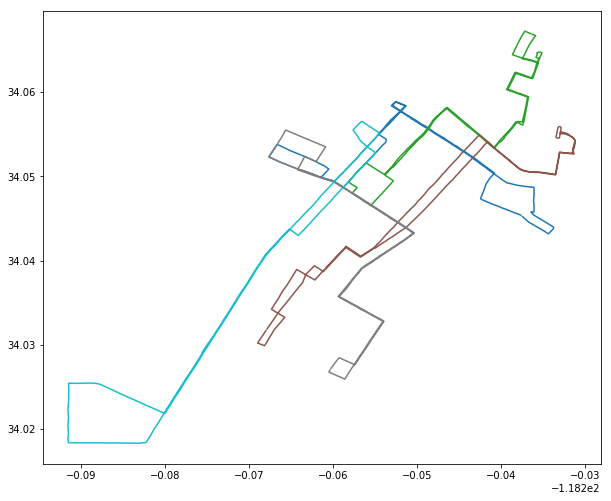

In [9]:
base = rte.plot(figsize = (10, 10), column = 'RouteName')
# From geopandas docs without modification. Uses contextily as ctx.
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [30]:
converted_rte = rte.to_crs(epsg=3857)
converted_rte.crs

{'init': 'epsg:3857', 'no_defs': True}

In [31]:
converted_gdf = gdf.to_crs(epsg=3857)
converted_gdf.crs

{'init': 'epsg:3857', 'no_defs': True}

In [32]:
# For my own learning:
gdf_sub1 = gdf.loc[lambda gdf: gdf.warning_name=='PDZ-R',:]
# or identical:
gdf_sub2 = gdf.loc[gdf['warning_name']=='PDZ-R',:]

# Now actual subset with multiple conditions
gdf_sub = converted_gdf.loc[(converted_gdf['warning_name']=='PDZ-R') & (converted_gdf['bus_number']==15341),:]

gdf_sub.head()
# print(gdf_sub3['geometry'].length)


,route_name,route_id,heading,driver_id,vehicle_id,bus_number,loc_time,warning_name,geometry
4,DASH B,296,S,8452,1628,15341,2018-06-01 08:49:00.000000,PDZ-R,POINT (-13162100.77800129 4036623.574962636)
5,DASH B,296,S,8452,1628,15341,2018-06-01 08:49:44.000000,PDZ-R,POINT (-13162136.95683579 4036417.05360774)
7,DASH B,296,S,8452,1628,15341,2018-06-01 08:54:45.000000,PDZ-R,POINT (-13162794.07578995 4036265.893636369)
8,DASH B,296,S,8452,1628,15341,2018-06-01 08:59:28.000000,PDZ-R,POINT (-13163284.88342485 4036463.812831831)
11,DASH B,296,S,8452,1628,15341,2018-06-01 09:01:33.000000,PDZ-R,POINT (-13163529.56366562 4036111.107904613)


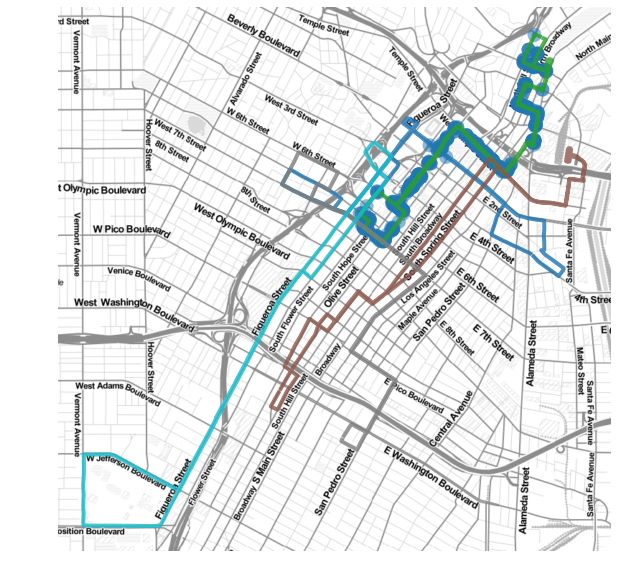

In [40]:
# Plot this subset, using 3857 projection
base = converted_rte.plot(figsize = (10, 10), column = 'RouteName', linewidth = 4, alpha = 0.8)
gdf_sub.plot(column ='route_name', ax=base, linewidth = 8, alpha = 0.5)
#converted_gdf.plot(column ='route_name')
add_basemap(base, zoom=14, url=ctx.sources.ST_TONER_LITE)
base.set_axis_off()